# Исследование надежности заемщиков.

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.
Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.


### Шаг 1. Обзор данных

In [1]:
import pandas as pd
clients = pd.read_csv('data.csv')
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


В таблице 12 столбцов. Тип данных разный: integer, float (необходимо в дальнейшем заменить на целочисленный), object. 

Согласно документации к данным:

* children — количество детей в семье
* days_employed — общий трудовой стаж в днях
* dob_years — возраст клиента в годах
* education — уровень образования клиента
* education_id — идентификатор уровня образования
* family_status — семейное положение
* family_status_id — идентификатор семейного положения
* gender — пол клиента
* income_type — тип занятости
* debt — имел ли задолженность по возврату кредитов
* total_income — ежемесячный доход
* purpose — цель получения кредита


In [2]:
clients.describe() 

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


In [3]:
clients.isna().mean()

children            0.000000
days_employed       0.100999
dob_years           0.000000
education           0.000000
education_id        0.000000
family_status       0.000000
family_status_id    0.000000
gender              0.000000
income_type         0.000000
debt                0.000000
total_income        0.100999
purpose             0.000000
dtype: float64

### Шаг 2.1 Заполнение пропусков

In [4]:
# clients.loc[clients['income_type'] == 'пенсионер','days_employed'] = clients.loc[clients['income_type'] == 'пенсионер','days_employed'].apply(lambda x: x/24) 
# уменьшим в 24 раза значение в столбце со стажем у пенсионеров (строка закомментирована, чтобы вычисления не были произведены еще раз)
clients['days_employed'] = abs(clients['days_employed']) # замена отрицательных значения на положительные 

days_employed_median = clients['days_employed'].median() 
total_income_median = clients['total_income'].median()

clients['days_employed'] = clients['days_employed'].fillna(days_employed_median)
clients['total_income'] = clients['total_income'].fillna(total_income_median)


В столбцах "days_employed" и "total_income" есть пропуски. Для 10% клиентов не указан общий трудовой стаж в днях и ежемесячный доход. Возможно, некоторые пользователи не смогли точно вспомнить свой стаж и не захотели указывать свою зарплату. 

В столбце "days_employed" большое количество значений отрицательные, вероятно, произошла ошибка при записи данных. Отрицательные значения заменены на положительные. Часть значений (изначально положительные, у пенсионеров) слишком большие, что вызывает вопрос о достоверности данных. Возможно, значения записаны не "в днях", а "в часах", поэтому они были переведены в подходящий формат. В идеале, наши догадки о происхождении ошибок необходимо было бы согласовать с коллегами, которые знают ответ на эти вопросы.

Пропущенные значения были заменены медианным значением. Медиана в данном случае подходит лучше, так как и стаж, и доход некоторых клиентов может сильно отличаться от большинства, поэтому среднее значение будет не объективно.

### Шаг 2.2 Проверка данных на аномалии и исправления.

In [5]:
clients.info() # проверим, не осталось ли пропусков

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     21525 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


### Шаг 2.3. Изменение типов данных.

In [6]:
clients['days_employed'] = clients['days_employed'].astype('int') # замена вещественного типа данных на целочисленный
clients['total_income'] = clients['total_income'].astype('int') # замена вещественного типа данных на целочисленный

### Шаг 2.4. Удаление дубликатов.

Проверим каждый столбец на наличие неявных дубликатов

In [7]:
clients.duplicated().sum()

54

In [8]:
clients = clients.drop_duplicates() # удалим все явные дубликаты
clients.duplicated().sum()

0

**Столбец 'children'**

In [9]:
clients['children'].value_counts()

 0     14107
 1      4809
 2      2052
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

В столбце с количеством детей в семье есть ошибки. 47 раз встречается "-1 ребенок" и 76 случаев с двадцатью детьми в семье (это представляется маловероятным). Заменим эти значения на медианное.  

In [10]:
children_median = clients.loc[clients.loc[:,'children'] != (20 and (-1))]['children'].median()
clients['children'] = clients['children'].replace(-1, int(children_median))
clients['children'] = clients['children'].replace(20, int(children_median))

clients['children'].value_counts() # теперь все ок

0    14230
1     4809
2     2052
3      330
4       41
5        9
Name: children, dtype: int64

**Столбец 'days_employed'** 

In [11]:
clients['days_employed'].value_counts()

2194      2126
133         16
327         16
438         15
223         14
          ... 
8200         1
9090         1
360849       1
2101         1
343937       1
Name: days_employed, Length: 9086, dtype: int64

Все выглядит ок

* Столбец 'dob_years'

In [12]:
clients['dob_years'].value_counts()

35    616
40    607
41    606
34    601
38    597
42    596
33    581
39    572
31    559
36    554
44    545
29    544
30    538
48    537
37    536
50    513
43    512
32    509
49    508
28    503
45    497
27    493
52    484
56    484
47    477
54    476
46    473
53    459
57    456
58    456
51    448
59    443
55    443
26    408
60    374
25    357
61    354
62    349
63    269
24    264
64    262
23    253
65    194
22    183
66    182
67    167
21    111
0     101
68     99
69     85
70     65
71     58
20     51
72     33
19     14
73      8
74      6
75      1
Name: dob_years, dtype: int64

Все выглядит ок

* Столбец 'education'

In [13]:
clients['education'].value_counts()

среднее                13705
высшее                  4710
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   273
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education, dtype: int64

В этом столбце есть одинаковые значения, записанные в разных регистрах. Приведем все к одному регистру.

In [14]:
clients['education'] = clients['education'].str.lower()
clients['education'].value_counts()

среднее                15188
высшее                  5251
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

**Столбец 'education_id'**

In [15]:
clients['education_id'].value_counts() 

1    15188
0     5251
2      744
3      282
4        6
Name: education_id, dtype: int64

Все выглядит ок

**Столбец 'family_status'**

In [16]:
clients['family_status'].value_counts() 

женат / замужем          12344
гражданский брак          4163
Не женат / не замужем     2810
в разводе                 1195
вдовец / вдова             959
Name: family_status, dtype: int64

Приведем все к одному регистру

In [17]:
clients['family_status'] = clients['family_status'].str.lower()
clients['family_status'].value_counts() 

женат / замужем          12344
гражданский брак          4163
не женат / не замужем     2810
в разводе                 1195
вдовец / вдова             959
Name: family_status, dtype: int64

**Столбец 'family_status_id'**

In [18]:
clients['family_status_id'].value_counts() 

0    12344
1     4163
4     2810
3     1195
2      959
Name: family_status_id, dtype: int64

Все выглядит ок

**Столбец 'gender'**

In [19]:
clients['gender'].value_counts() 

F      14189
M       7281
XNA        1
Name: gender, dtype: int64

Есть одно некорректное значение, но оно только одно, поэтому можно все оставить как есть.

**Столбец 'income_type'**

In [20]:
clients['income_type'].value_counts() 

сотрудник          11091
компаньон           5080
пенсионер           3837
госслужащий         1457
безработный            2
предприниматель        2
студент                1
в декрете              1
Name: income_type, dtype: int64

Все выглядит ок

**Столбец 'debt'**

In [21]:
clients['debt'].value_counts() 

0    19730
1     1741
Name: debt, dtype: int64

Все выглядит ок

**Столбец 'total_income'**

In [22]:
clients['total_income'].value_counts() 

145017    2121
133122       3
104693       3
204827       3
107832       3
          ... 
300306       1
381117       1
70100        1
110461       1
82047        1
Name: total_income, Length: 18606, dtype: int64

Все выглядит ок

**Столбец 'purpose'**

In [23]:
clients['purpose'].value_counts() 

свадьба                                   793
на проведение свадьбы                     773
сыграть свадьбу                           769
операции с недвижимостью                  675
покупка коммерческой недвижимости         662
покупка жилья для сдачи                   652
операции с жильем                         652
операции с коммерческой недвижимостью     650
покупка жилья                             646
жилье                                     646
покупка жилья для семьи                   638
строительство собственной недвижимости    635
недвижимость                              633
операции со своей недвижимостью           627
строительство жилой недвижимости          625
покупка недвижимости                      621
покупка своего жилья                      620
строительство недвижимости                619
ремонт жилью                              607
покупка жилой недвижимости                606
на покупку своего автомобиля              505
заняться высшим образованием      

Здесь точно можно было бы объединить значения по смыслу, но пока оставим все как есть.

### Шаг 2.5. Формирование дополнительных датафреймов словарей, декомпозиция исходного датафрейма.

In [24]:
educ_dict = clients[['education_id', 'education']] # создаем первый словарь
fam_stat_dict = clients[['family_status', 'family_status_id']] # создаем второй словарь
clients_log = clients.drop(['education', 'family_status'], axis=1) # остаток нашей таблицы


In [25]:
educ_dict = educ_dict.drop_duplicates().reset_index(drop=True) # удалим дубликаты
fam_stat_dict = fam_stat_dict.drop_duplicates().reset_index(drop=True) # удалим дубликаты

### Шаг 2.6. Категоризация дохода.

In [26]:
clients['total_income'].value_counts()
def income_category(total_income):
    """
    Возвращает категорию по значению дохода, используя правила:
    * 0–30000 — 'E';
    * 30001–50000 — 'D';
    * 50001–200000 — 'C';
    * 200001–1000000 — 'B';
    * 1000001 и выше — 'A'.
    """
    if total_income <= 30000:
        return 'E'
    if total_income <= 50000:
        return 'D'
    if total_income <= 200000:
        return 'C'
    if total_income <= 1000000:
        return 'B'
    return 'A'

clients['total_income_category'] = clients['total_income'].apply(income_category)
clients.head() # проверим результат 

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,total_income_category
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,B
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,C
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,C
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,B
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,C


### Шаг 2.7. Категоризация целей кредита.

In [27]:
clients['purpose'].value_counts()
def purpose_category(purpose):
    """
    Функция, которая на остовании данных из столбца 'purpose' определит, в какую категорию попадет значение.
    Категории:
    * 'операции с автомобилем',
    * 'операции с недвижимостью',
    * 'проведение свадьбы',
    * 'получение образования'
    """
    if 'автомобил' in purpose:
        return 'операции с автомобилем'
    if 'свадьб' in purpose:
        return 'проведение свадьбы'
    if 'образован' in purpose:
        return 'получение образования'
    elif 'жил' or 'недвижимост' in purpose:
        return 'операции с недвижимостью'
    


clients['purpose_category'] = clients['purpose'].apply(purpose_category)
clients.head(15) # проверим результат

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,total_income_category,purpose_category
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,B,операции с недвижимостью
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,C,операции с автомобилем
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,C,операции с недвижимостью
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,B,получение образования
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,C,проведение свадьбы
5,0,926,27,высшее,0,гражданский брак,1,M,компаньон,0,255763,покупка жилья,B,операции с недвижимостью
6,0,2879,43,высшее,0,женат / замужем,0,F,компаньон,0,240525,операции с жильем,B,операции с недвижимостью
7,0,152,50,среднее,1,женат / замужем,0,M,сотрудник,0,135823,образование,C,получение образования
8,2,6929,35,высшее,0,гражданский брак,1,F,сотрудник,0,95856,на проведение свадьбы,C,проведение свадьбы
9,0,2188,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425,покупка жилья для семьи,C,операции с недвижимостью


# Ответы на вопросы

**1. Есть ли зависимость между количеством детей и возвратом кредита в срок?**

In [28]:
clients.groupby('children')['debt'].agg(['count', 'mean']).reset_index()
# можно вывести эту же таблицу с помощью pivot_table, но groupby проще
# clients.pivot_table(index='children', values='debt', aggfunc=['count', 'mean'])

,children,count,mean
0,0,14230,0.075334
1,1,4809,0.092327
2,2,2052,0.094542
3,3,330,0.081818
4,4,41,0.097561
5,5,9,0.000000


<AxesSubplot:xlabel='children'>

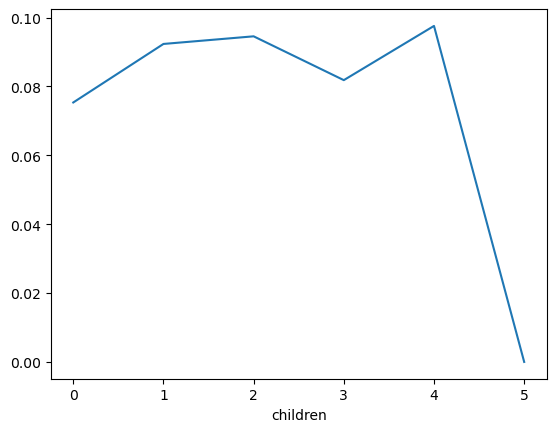

In [29]:
clients.groupby('children')['debt'].agg('mean').plot() # для наглядности посмотрим на графике

В целом, с увеличением количества детей мы видим, что увеличивается и количество просроченных кредитов. Если для семей без детей этот показатель равен 7.5%, то в семье, например, с двумя детьми - уже 9.5%. Из этой тенденции выбиваются семьи с тремя детьми: для них этот показатель равен 8.1% (возможно, мы не можем адекватно оценивать данные по семьям с тремя и более детьми, так как их количество в выборке недостаточное).

**2. Есть ли зависимость между семейным положением и возвратом кредита в срок?**

In [30]:
t = clients.groupby('family_status')['debt'].agg(['count', 'mean']).reset_index()
t.sort_values(by='mean')

,family_status,count,mean
1,вдовец / вдова,959,0.065693
0,в разводе,1195,0.071130
3,женат / замужем,12344,0.075421
2,гражданский брак,4163,0.093202
4,не женат / не замужем,2810,0.097509


Мы видим, что самыми надежными категориями клиентов являются вдовцы/вдовы (6.6% задолженностей по кредиту), в разводе (7.1%) и женатые/замужние (7.5%). Клиенты, состоящие в гражданском браке и неженатые/незамужние имеют задолженности намного чаще (9.3% и 9.8% соответственно). Можно сделать предположение, что столкновение с институтом брака делает людей более ответственными. 

**3. Есть ли зависимость между уровнем дохода и возвратом кредита в срок?**

In [31]:
clients.groupby('total_income_category')['debt'].agg(['count', 'mean']).reset_index()
# Посмотрим зависимость между уровнем дохода по категориям, сформированным ранее
# Категории: 
# A 1000001 и выше
# B 200001–1000000
# C 50001–200000
# D 30001–50000
# E 0–30000 

,total_income_category,count,mean
0,A,25,0.080000
1,B,5041,0.070621
2,C,16033,0.084825
3,D,350,0.060000
4,E,22,0.090909


Сделать однозначный вывод о зависимости между уровнем дохода (по категориям) и возвратом кредита в срок не представляется возможным. Клиентов с зарплатой выше 1 млн рублей и ниже 50 тыс рублей в данных недостаточно для анализа. Остается лишь две категории: клиенты с высоким доходом (от 200 тыс до 1 млн) возвращают кредит в 7% случаев; со средним доходом (от 50 тыс до 200 тыс рублей) - в 8.5% случаев.

**4. Как разные цели кредита влияют на его возврат в срок?**

In [32]:
t = clients.groupby('purpose_category')['debt'].agg(['count', 'mean']).reset_index()
t.sort_values(by='mean')

,purpose_category,count,mean
1,операции с недвижимостью,10814,0.072314
3,проведение свадьбы,2335,0.079657
2,получение образования,4014,0.092177
0,операции с автомобилем,4308,0.093547


Кредит на покупку недвижимости имеет самый маленький показатель по задолженности - 7.2%. Далее идут свадьба (8%), образование (9.2%), и покупка автомобиля (9.4%). Можно сделать предположение, что чем больше сумма кредита, тем более ответственно кредиторы относятся к займу. 

# Общий вывод:

В ходе работы была проанализировна статистика о платёжеспособности клиентов, проведена предобработка данных (заполнены пропуски, обработаны артефакты и дубликаты, изменены типы данных, проведена категоризация некоторых переменных) и получены ответы на поставленные вопросы.

*Основные выводы:*

* Количество детей негативно влияет на вероятность выплатить кредит в срок;
* Люди, состоящие в браке в настоящий момент или в прошлом, являются более надежными заемщиками, чем незамужние/неженатые или живующие в гражданском браке;
* Зависимость между заработной платой и вероятностью задолженности не выявлена;
* Чем больше сумма кредита, тем выше способность потенциального заёмщика вернуть кредит банку в срок.

